distribution max min is 4.592855453491211 -3.950523614883423
loss at step 0 327.0367431640625
mcmc sampling mean -2.426431655883789
mcmc sampling std 1.4524929523468018


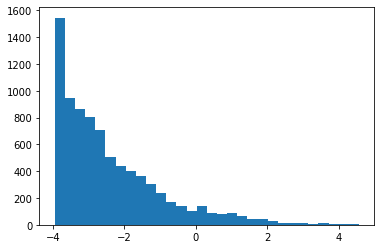

loss at step 1000 311.697265625
mcmc sampling mean 0.08577699959278107
mcmc sampling std 1.0890722274780273


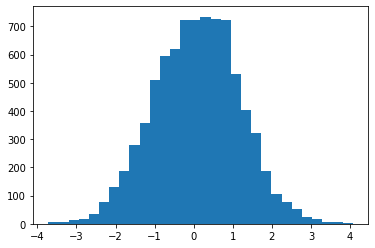

loss at step 2000 310.26751708984375
mcmc sampling mean 0.10331989824771881
mcmc sampling std 1.1141010522842407


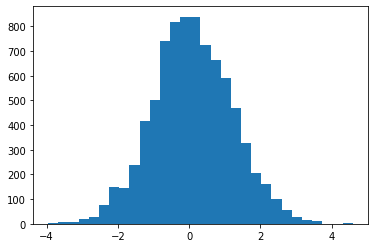

loss at step 3000 311.8204650878906
mcmc sampling mean -0.029285117983818054
mcmc sampling std 1.0671501159667969


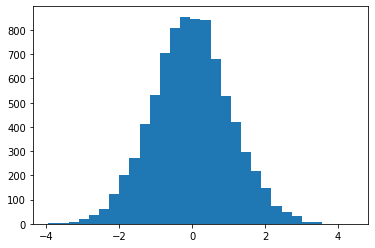

loss at step 4000 310.5473327636719
mcmc sampling mean -0.1456352323293686
mcmc sampling std 1.0311592817306519


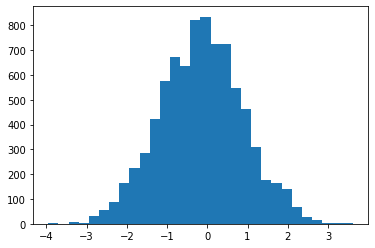

loss at step 5000 311.24774169921875
mcmc sampling mean -0.032673612236976624
mcmc sampling std 1.0220273733139038


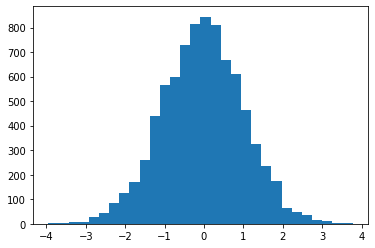

loss at step 6000 310.78106689453125
mcmc sampling mean 0.057592667639255524
mcmc sampling std 1.09661865234375


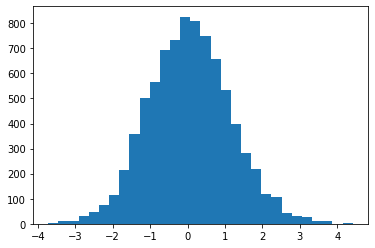

loss at step 7000 310.2179260253906
mcmc sampling mean 0.3303722143173218
mcmc sampling std 1.1390243768692017


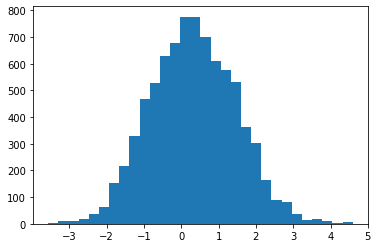

loss at step 8000 310.0810546875
mcmc sampling mean -0.1820473074913025
mcmc sampling std 1.123287320137024


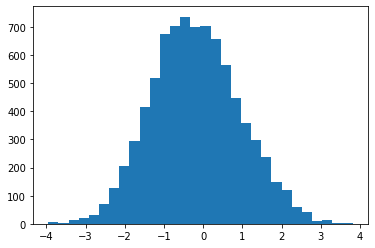

loss at step 9000 309.87689208984375
mcmc sampling mean -0.05178212374448776
mcmc sampling std 1.116997480392456


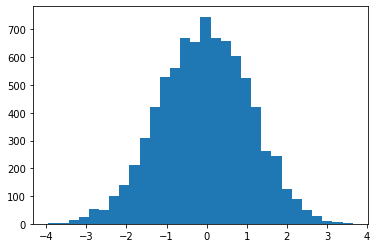

In [2]:
from agents import mcmc
from agents.utils import tile_batch
from losses import emb_losses
from network import mlp_ebm
import torch
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn import manifold, datasets
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
# torch.cuda.set_device(2)
device = torch.device('cuda')
def get_sample_distribution():
    # Construct Gaussian Mixture Model in 1D consisting of 5 equally
    # weighted normal distributions
    mix = D.Categorical(torch.ones(5,))
    comp = D.Normal(torch.randn(5,), torch.rand(5,))
    gmm = D.MixtureSameFamily(mix, comp)
    # return gmm
    # TODO: debug
    return D.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

def get_distribution_sample(num_sample:int):
    gmm = get_sample_distribution()
    return gmm.sample([num_sample])[:,None].float()

def get_dataset_sample(num_sample:int):
    X, y = datasets.make_circles(
    n_samples=num_sample, factor=0.5, noise=0.05, random_state=0)
    return X

def make_counter_example_actions(
      observations,  # B x obs_spec
      expanded_actions,  # B x 1 x act_spec
      batch_size,
      cloning_network,
      num_counter_examples, act_shape, act_min=-100, act_max=100):
    """Given observations and true actions, create counter example actions."""
    # Note that T (time dimension) would be included in obs_spec.
    # TODO: obtain action max and min
    high, low = act_max, act_min
    maybe_tiled_obs_n = tile_batch(observations,
                                                  num_counter_examples)
    # Counter example actions [B x num_counter_examples x act_spec]
    random_uniform_example_actions = \
        torch.distributions.uniform.Uniform(low,high).sample(\
            [batch_size, num_counter_examples]+list(act_shape))
    random_uniform_example_actions = torch.reshape(
          random_uniform_example_actions,
          (batch_size * num_counter_examples, -1))
    # Use all uniform actions to seed the optimization
    _, init_example_actions, _ = mcmc.iterative_dfo(
        cloning_network,
        batch_size,
        maybe_tiled_obs_n,
        random_uniform_example_actions,
        policy_state=(),
        num_action_samples=num_counter_examples,
        min_actions=low * np.ones(act_shape),
        max_actions=high * np.ones(act_shape),
        num_iterations=3)
    
    _, counter_example_actions, _ = mcmc.iterative_dfo(
        cloning_network,
        batch_size,
        maybe_tiled_obs_n,
        init_example_actions,
        policy_state=(),
        num_action_samples=num_counter_examples,
        min_actions=low * np.ones(act_shape),
        max_actions=high * np.ones(act_shape),
        num_iterations=3)
    def concat_and_squash_actions(counter_example, action):
      return torch.reshape(
          torch.concat([counter_example, action], axis=1),
          [-1] + (act_shape))
    counter_example_actions = counter_example_actions.reshape([batch_size, num_counter_examples, -1])
    # print("check mcmc output shape",counter_example_actions.shape, expanded_actions.shape)
    # Batch consists of num_counter_example rows followed by 1 true action.
    # [B * (n + 1) x act_spec]
    combined_true_counter_actions = \
        concat_and_squash_actions(counter_example_actions, expanded_actions)
    return counter_example_actions, combined_true_counter_actions


def train(useGaussian:bool):
    if(useGaussian):
        gmm = get_sample_distribution()
        # get sampling space max and min
        large_sample = gmm.sample([10000])
        act_shape = [1]
        exp_name = 'use gaussian'
    else:
        large_sample = get_dataset_sample(10000)
        act_shape = [2]
        exp_name = 'use sklearn'
    path = './mcmc_exp/'+exp_name+'/'
    if os.path.exists(path):
        os.makedirs(path)
    sample_max = large_sample.max().item()
    sample_min = large_sample.min().item()
    print("distribution max min is", sample_max, sample_min)
    batch_size = 64
    num_counter_sample = 128
    
    # default obs
    obs = torch.rand([batch_size,1], dtype=torch.float32)
    network = mlp_ebm.MLPEBM((act_shape[0]+1) , 1).to(device)
    # print (network,[param.shape for param in list(network.parameters())] )
    optim = torch.optim.Adam(network.parameters(), lr=1e-3)
    maybe_tiled_obs = tile_batch(obs, num_counter_sample + 1)

    for i in range(10000):
        # get data from target distribution
        if (useGaussian):
            data = gmm.sample([batch_size])[:,None].float()
        else:
            target_data = get_dataset_sample(batch_size)
            data = torch.tensor(target_data)[:,None].float()
        # print("data",data)
        # data.requires_grad_(True).to(device)
        # [B * n , act_spec], [B * (n + 1) , act_spec]
        with torch.no_grad():
            counter_example_actions, combined_true_counter_actions = \
                make_counter_example_actions(obs, data,batch_size,network,\
                    num_counter_sample, act_shape, sample_min, sample_max)
        network_inputs = (maybe_tiled_obs,
                        combined_true_counter_actions)
        # [B * n+1]
        predictions = network(network_inputs)
        # print("check counter example shape",counter_example_actions.shape, combined_true_counter_actions.shape)
        predictions = torch.reshape(predictions,
                                    [batch_size, num_counter_sample + 1])
        optim.zero_grad()
        loss, _ = emb_losses.info_nce(predictions,batch_size,num_counter_sample)
        if i%1000 == 0:
            print("loss at step",i, loss.sum().item())
            if useGaussian:
                # check mcmc kl distance
                sampling = counter_example_actions.reshape([-1]).cpu().numpy()
                mu = counter_example_actions.mean().item()
                std = counter_example_actions.std().item()
                print("mcmc sampling mean", mu)
                print("mcmc sampling std", std)
                # x = np.linspace(mu - 3*std, mu + 3*std, 100)
                # param = scipy.stats.norm.fit(counter_example_actions.cpu().numpy())
                # fit_pdf = scipy.stats.norm.pdf(x, param[0], param[1])
                # plt.scatter(samples, y)
                plt.hist(sampling, bins=30)
                # plt.plot(x, fit_pdf)
                # plt.savefig(path+str(i)+'.png')
                plt.show()
            else:
                (fig, subplots) = plt.subplots(1,2, figsize=(8,8))
                ax1 = subplots[0]
                ax2 = subplots[1]
                sampling = counter_example_actions.cpu().numpy()
                ax1.scatter(sampling[:, 0], sampling[:, 1], c="r")
                ax2.scatter(target_data[:,0], target_data[:,1])
                plt.axis("tight")
                plt.show()
        loss.sum().backward()
        optim.step()
    

if __name__ == '__main__':
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    train(useGaussian=True)


distribution max min is 3.8550848960876465 -3.7246994972229004
loss at step 0 336.4646301269531
mcmc sampling mean 0.18877525627613068
mcmc sampling std 2.1850860118865967


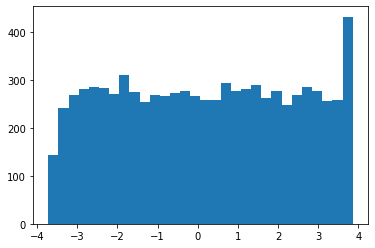

loss at step 1000 298.52178955078125
mcmc sampling mean -0.03177806735038757
mcmc sampling std 1.6640892028808594


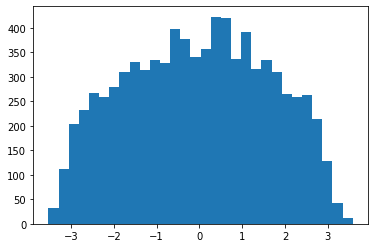

loss at step 2000 292.4377746582031
mcmc sampling mean 0.03123648464679718
mcmc sampling std 1.711953043937683


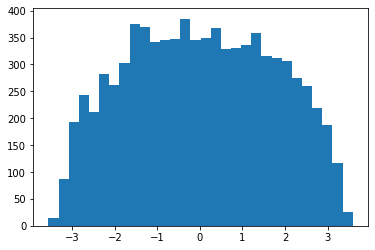

loss at step 3000 294.329833984375
mcmc sampling mean 0.07047438621520996
mcmc sampling std 1.6478965282440186


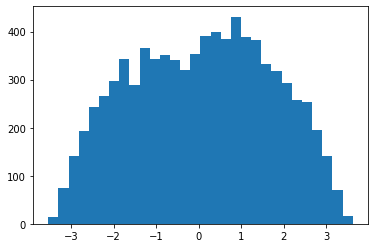

loss at step 4000 289.853759765625
mcmc sampling mean 0.016063926741480827
mcmc sampling std 1.6208010911941528


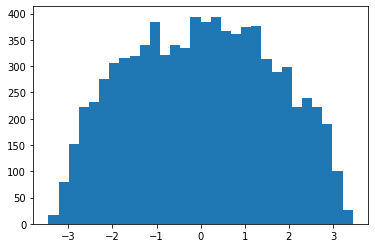

loss at step 5000 290.768310546875
mcmc sampling mean 0.04762981832027435
mcmc sampling std 1.624398112297058


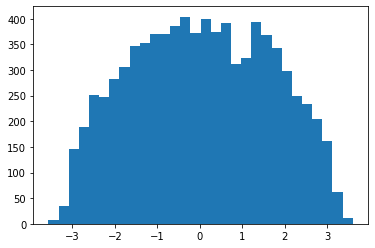

loss at step 6000 298.869873046875
mcmc sampling mean 0.02636781334877014
mcmc sampling std 1.639534592628479


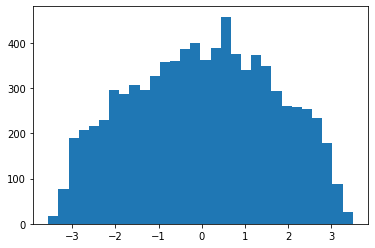

loss at step 7000 294.2672119140625
mcmc sampling mean 0.042616330087184906
mcmc sampling std 1.6700630187988281


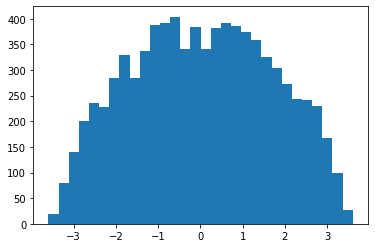

loss at step 8000 293.6826171875
mcmc sampling mean 0.03735312819480896
mcmc sampling std 1.6940562725067139


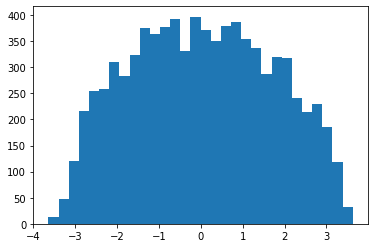

loss at step 9000 293.393798828125
mcmc sampling mean 0.06879190355539322
mcmc sampling std 1.7281116247177124


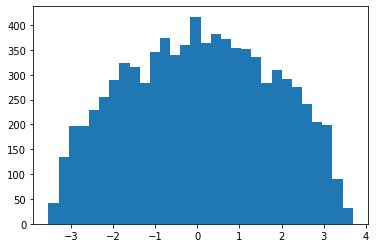

In [1]:
from agents import mcmc
from agents.utils import tile_batch
from losses import emb_losses
from network import mlp_ebm
import torch
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn import manifold, datasets
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
# torch.cuda.set_device(2)
device = torch.device('cuda')
def get_sample_distribution():
    # Construct Gaussian Mixture Model in 1D consisting of 5 equally
    # weighted normal distributions
    mix = D.Categorical(torch.ones(5,))
    comp = D.Normal(torch.randn(5,), torch.rand(5,))
    gmm = D.MixtureSameFamily(mix, comp)
    # return gmm
    # TODO: debug
    return D.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

def get_distribution_sample(num_sample:int):
    gmm = get_sample_distribution()
    return gmm.sample([num_sample])[:,None].float()

def get_dataset_sample(num_sample:int):
    X, y = datasets.make_circles(
    n_samples=num_sample, factor=0.5, noise=0.05, random_state=0)
    return X

def make_counter_example_actions(
      observations,  # B x obs_spec
      expanded_actions,  # B x 1 x act_spec
      batch_size,
      cloning_network,
      num_counter_examples, act_shape, act_min=-100, act_max=100,
      langevin=False):
    """Given observations and true actions, create counter example actions."""
    # Note that T (time dimension) would be included in obs_spec.
    # TODO: obtain action max and min
    high, low = act_max, act_min
    maybe_tiled_obs_n = tile_batch(observations,
                                                  num_counter_examples)
    # Counter example actions [B x num_counter_examples x act_spec]
    random_uniform_example_actions = \
        torch.distributions.uniform.Uniform(low,high).sample(\
            [batch_size, num_counter_examples]+list(act_shape))
    random_uniform_example_actions = torch.reshape(
          random_uniform_example_actions,
          (batch_size * num_counter_examples, -1))
    # Use all uniform actions to seed the optimization
    if langevin:
        counter_example_actions = mcmc.langevin_actions_given_obs(
            cloning_network,
            maybe_tiled_obs_n,
            random_uniform_example_actions,
            policy_state=(),
            min_actions=low * torch.ones(act_shape),
            max_actions=high * torch.ones(act_shape),
            return_chain=False,
            grad_norm_type='inf',
            num_action_samples=num_counter_examples)
    else:
        _, counter_example_actions, _ = mcmc.iterative_dfo(
        cloning_network,
        batch_size,
        maybe_tiled_obs_n,
        random_uniform_example_actions,
        policy_state=(),
        num_action_samples=num_counter_examples,
        min_actions=low * torch.ones(act_shape),
        max_actions=high * torch.ones(act_shape),
        num_iterations=3)
    
    def concat_and_squash_actions(counter_example, action):
      return torch.reshape(
          torch.concat([counter_example, action], axis=1),
          [-1] + (act_shape))
    counter_example_actions = counter_example_actions.reshape([batch_size, num_counter_examples, -1])
    # print("check mcmc output shape",counter_example_actions.shape, expanded_actions.shape)
    # Batch consists of num_counter_example rows followed by 1 true action.
    # [B * (n + 1) x act_spec]
    combined_true_counter_actions = \
        concat_and_squash_actions(counter_example_actions, expanded_actions)
    return counter_example_actions, combined_true_counter_actions


def train(useGaussian:bool):
    if(useGaussian):
        gmm = get_sample_distribution()
        # get sampling space max and min
        large_sample = gmm.sample([10000])
        act_shape = [1]
        exp_name = 'use gaussian'
    else:
        large_sample = get_dataset_sample(10000)
        act_shape = [2]
        exp_name = 'use sklearn'
    path = './mcmc_exp/'+exp_name+'/'
    if os.path.exists(path):
        os.makedirs(path)
    sample_max = large_sample.max().item()
    sample_min = large_sample.min().item()
    print("distribution max min is", sample_max, sample_min)
    batch_size = 64
    num_counter_sample = 128
    
    # default obs
    obs = torch.rand([batch_size,1], dtype=torch.float32)
    network = mlp_ebm.MLPEBM((act_shape[0]+1) , 1).to(device)
    # print (network,[param.shape for param in list(network.parameters())] )
    optim = torch.optim.Adam(network.parameters(), lr=1e-3)
    maybe_tiled_obs = tile_batch(obs, num_counter_sample + 1)

    for i in range(10000):
        # get data from target distribution
        if (useGaussian):
            data = gmm.sample([batch_size])[:,None].float()
        else:
            target_data = get_dataset_sample(batch_size)
            data = torch.tensor(target_data)[:,None].float()
        # print("data",data)
        # data.requires_grad_(True).to(device)
        # [B * n , act_spec], [B * (n + 1) , act_spec]

        counter_example_actions, combined_true_counter_actions = \
                make_counter_example_actions(obs, data,batch_size,network,\
                    num_counter_sample, act_shape, sample_min, sample_max, langevin=True)
        network_inputs = (maybe_tiled_obs,
                        combined_true_counter_actions.detach())
        # [B * n+1]
        predictions = network(network_inputs)
        # print("check counter example shape",counter_example_actions.shape, combined_true_counter_actions.shape)
        predictions = torch.reshape(predictions,
                                    [batch_size, num_counter_sample + 1])
        optim.zero_grad()
        loss, _ = emb_losses.info_nce(predictions,batch_size,num_counter_sample)
        if i%1000 == 0:
            print("loss at step",i, loss.sum().item())
            if useGaussian:
                # check mcmc kl distance
                sampling = counter_example_actions.reshape([-1]).cpu().numpy()
                mu = counter_example_actions.mean().item()
                std = counter_example_actions.std().item()
                print("mcmc sampling mean", mu)
                print("mcmc sampling std", std)
                plt.hist(sampling, bins=30)
                # plt.plot(x, fit_pdf)
                # plt.savefig(path+str(i)+'.png')
                plt.show()
            else:
                (fig, subplots) = plt.subplots(1,2, figsize=(8,8))
                ax1 = subplots[0]
                ax2 = subplots[1]
                sampling = counter_example_actions.cpu().numpy()
                ax1.scatter(sampling[:, 0], sampling[:, 1], c="r")
                ax2.scatter(target_data[:,0], target_data[:,1])
                plt.axis("tight")
                plt.show()
        loss.sum().backward()
        optim.step()
    

if __name__ == '__main__':
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    train(useGaussian=True)
